# Baysian Two-way Fixed Effects

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [31]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

,island_ids,year,pseudo_year,region_codes,prefecture_codes,population,treatment_group,treatment_group_mainland,bridge_year,pseudo_bridge_year,...,connect_mainland_year,after_treatment_mainland,income,area_km2,distance_m,log_pop,pop_star,log_pop_star,time_since_treatment,is_already_treated
0,67,1970,1970,32202,32,NaN,1,1,1999,1999,...,1999,0,NaN,0.28,615.0,NaN,NaN,NaN,-29,0
1,67,1975,1975,32202,32,NaN,1,1,1999,1999,...,1999,0,NaN,0.28,615.0,NaN,NaN,NaN,-24,0
2,67,1980,1980,32202,32,NaN,1,1,1999,1999,...,1999,0,NaN,0.28,615.0,NaN,NaN,NaN,-19,0
3,67,1985,1985,32202,32,NaN,1,1,1999,1999,...,1999,0,4.243674e+07,0.28,615.0,NaN,NaN,NaN,-14,0
4,67,1990,1990,32202,32,NaN,1,1,1999,1999,...,1999,0,4.786833e+07,0.28,615.0,NaN,NaN,NaN,-9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,226,2000,2000,39424,39,398.0,1,1,1957,1957,...,1957,1,5.113370e+02,0.56,110.0,5.986452,-51.742797,-0.002503,43,1
1859,226,2005,2005,39424,39,365.0,1,1,1957,1957,...,1957,1,4.533435e+02,0.56,110.0,5.899897,88.193373,-0.004061,48,1
1860,226,2010,2010,39424,39,343.0,1,1,1957,1957,...,1957,1,3.903833e+02,0.56,110.0,5.837730,256.163002,0.065408,53,1
1861,226,2015,2015,39424,39,284.0,1,1,1957,1957,...,1957,1,4.064721e+02,0.56,110.0,5.648974,406.395500,0.035329,58,1


<Axes: xlabel='log_pop', ylabel='Count'>

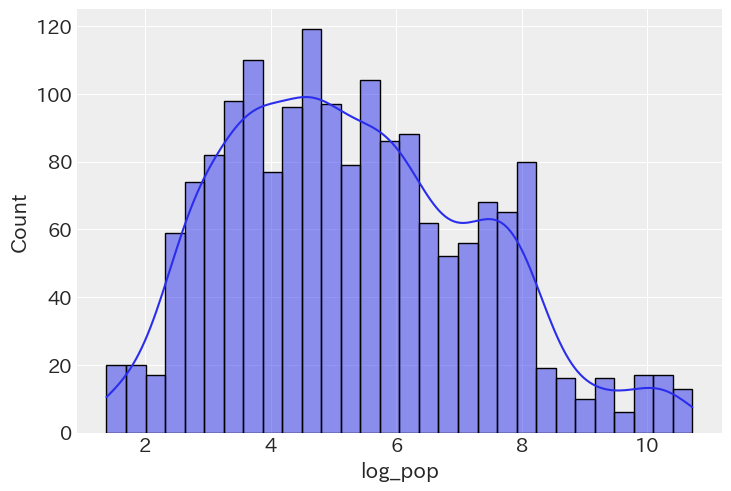

In [32]:
sns.histplot(df['log_pop'], bins=30, kde=True)

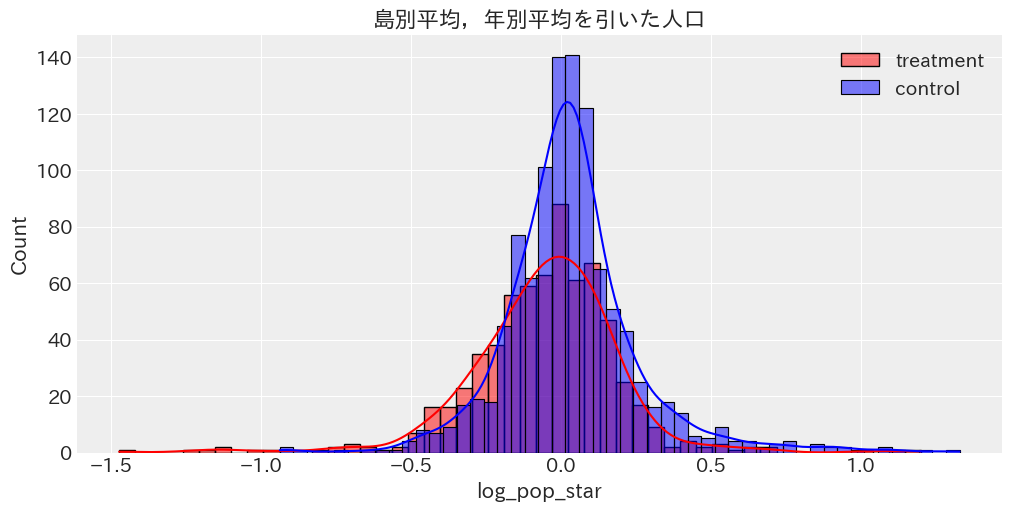

In [64]:
plt.figure(figsize=(10, 5))
sns.histplot(df['log_pop_star'][df['treatment_group'] == 1], bins=50, kde=True, color='red', label='treatment')
sns.histplot(df['log_pop_star'][df['treatment_group'] == 0], bins=50, kde=True, color='blue', label='control')
plt.title('島別平均，年別平均を引いた人口')
plt.legend()
plt.show()

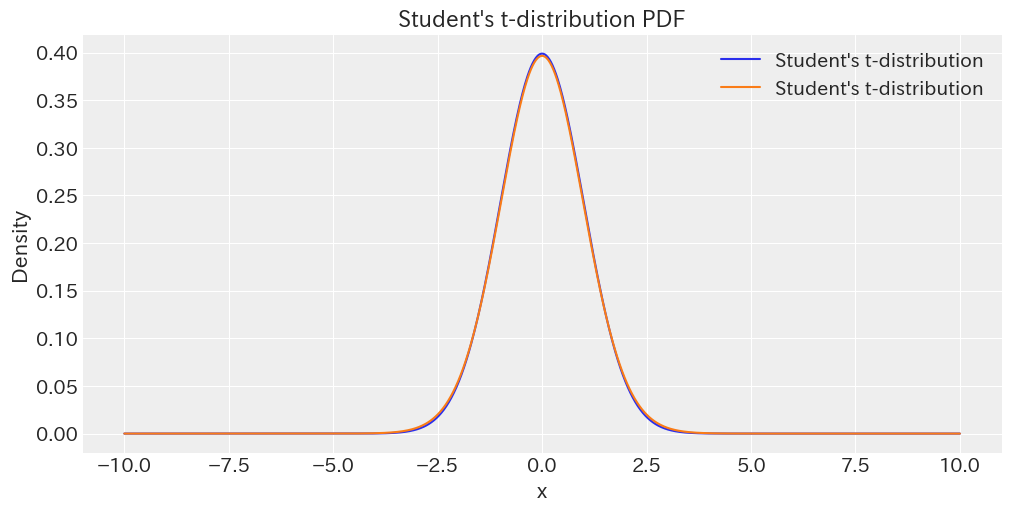

In [34]:
plt.figure(figsize=(10, 5))
x = np.linspace(-10, 10, 1000)
N = stats.norm.pdf(x, loc=0, scale=1)
t = stats.t.pdf(x, df=43, loc=0, scale=1)
plt.plot(x, N, label='Student\'s t-distribution')
plt.plot(x, t, label='Student\'s t-distribution')
plt.title('Student\'s t-distribution PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

## TWFE

$$
\log{Y^*_{it}} = \log{Y_{it}} - \bar{\log{{Y}_{i}}}
$$

$$
\begin{aligned}
\log{Y^*_{it}} &\sim \mathcal{t}(\nu, \mu_{it}, \sigma^2) \\
\mu_{it} &= \alpha + \beta \cdot T_{it} + \eta_t \\
\alpha &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(0, 1) \\
\eta_t &\sim \mathcal{N}(0, 1) \\
\nu &\sim \mathcal{Exponential}(\lambda = 1/30) \\
\sigma &\sim \mathcal{Cauchy}^+(\beta=1) \\
\end{aligned}
$$

### ベイズモデル

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


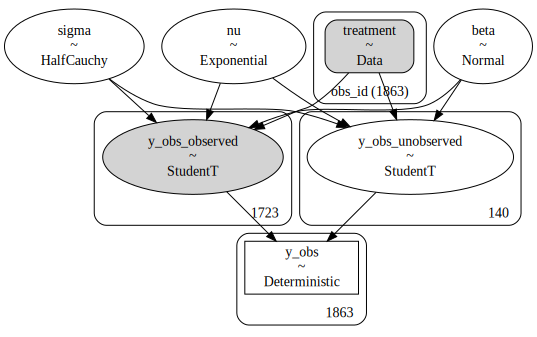

In [52]:
year = dmatrix('C(year) -1', df, return_type='dataframe')
year.drop('C(year)[1960]', axis=1, inplace=True)
n_years = year.shape[1]

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model:
    # data
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=100)

    # expectation
    mu = beta * treatment

    # likelihood
    nu = pm.Exponential('nu', lam=1/30)
    sigma = pm.HalfCauchy('sigma', beta=100)
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'])

pm.model_to_graphviz(model)

In [53]:
with model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro',
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [54]:
az.summary(trace, hdi_prob=.95, var_names=['beta', 'sigma', 'nu'], stat_funcs={"median": np.median})

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median
beta,-0.006,0.009,-0.024,0.010,0.000,0.000,5652.0,2828.0,1.0,-0.005
sigma,0.147,0.005,0.138,0.157,0.000,0.000,3395.0,3387.0,1.0,0.147
nu,2.847,0.228,2.385,3.288,0.005,0.004,2079.0,3154.0,1.0,2.840


In [38]:
exp_beta = np.exp(-1.421) - 1
print(f'{exp_beta:.3%}')

-75.853%


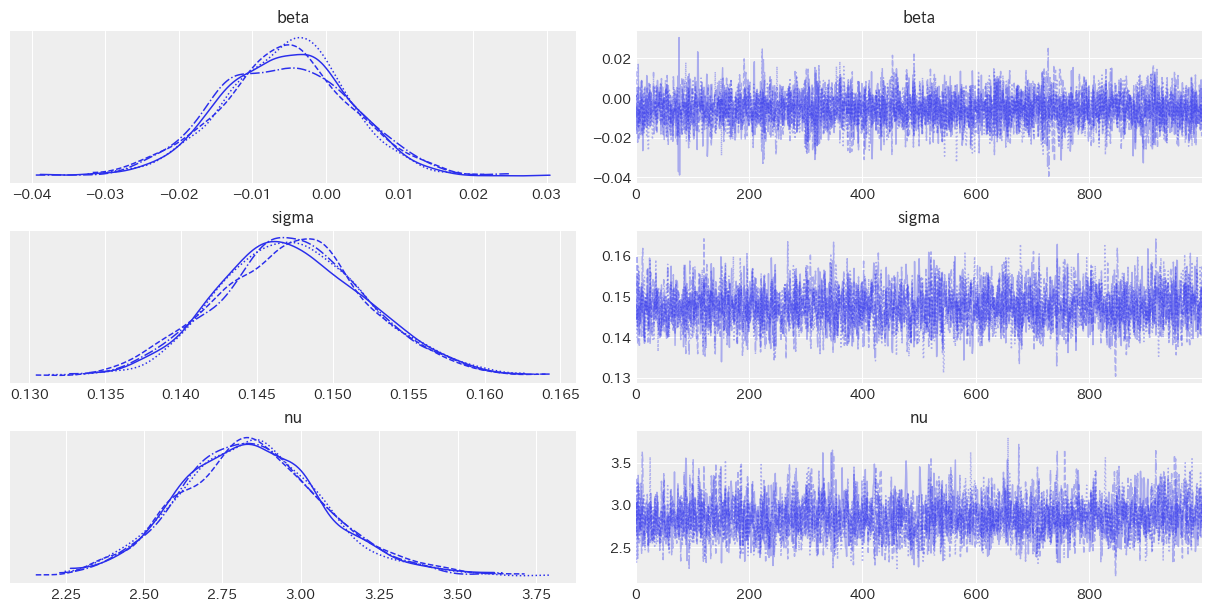

In [56]:
az.plot_trace(trace, var_names=['beta', 'sigma', 'nu'], );

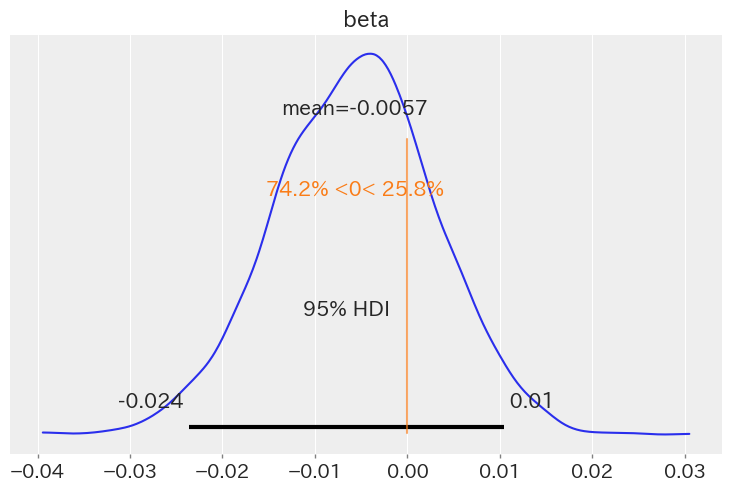

In [57]:
az.plot_posterior(trace, var_names=['beta'], ref_val=0, hdi_prob=.95);

In [58]:
with model:
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Output()

Sampling: [y_obs_observed]


Output()

In [59]:
az.waic(trace)

Computed from 4000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   203.48    44.89
p_waic        3.18        -

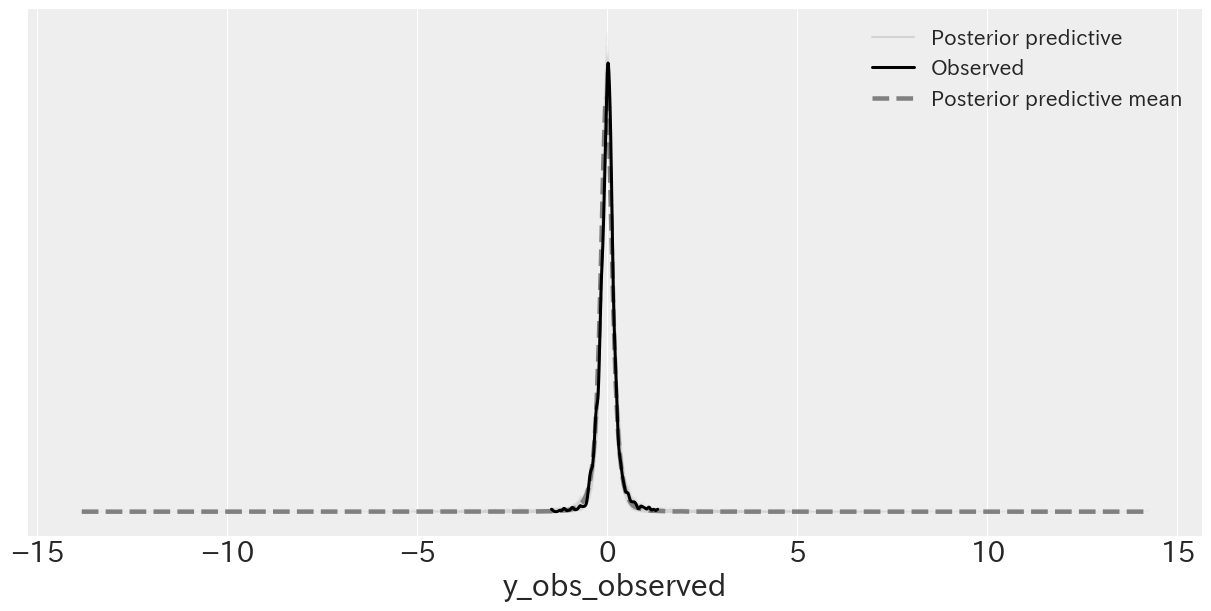

In [60]:
az.plot_ppc(
    trace,
    num_pp_samples=100,
    kind='kde',
    figsize=(12, 6),
    colors=('lightgray', 'black', 'gray')
);

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


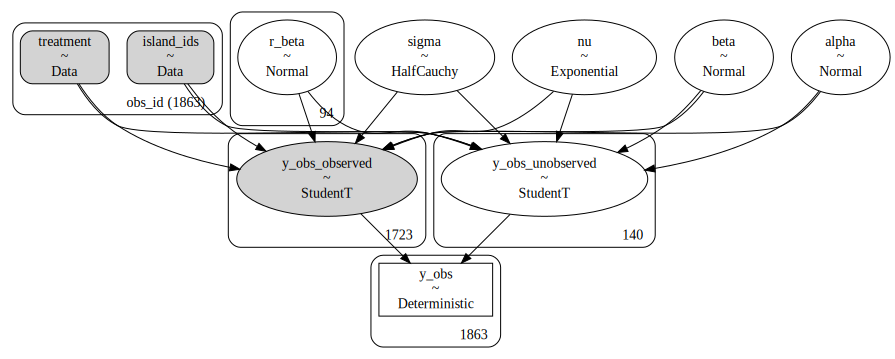

In [ ]:
year = dmatrix('C(year) -1', df, return_type='dataframe')
year.drop('C(year)[1960]', axis=1, inplace=True)
n_years = year.shape[1]

# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    r_beta = pm.Normal('r_beta', mu=0, sigma=100, shape=n_islands)

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=100)
    sigma = pm.HalfCauchy('sigma', beta=100)
    nu = pm.Exponential('nu', lam=1/30)

    # expectation
    mu = (beta + r_beta[island_ids]) * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'])

pm.model_to_graphviz(model_h)

In [46]:
with model_h:
    trace_h = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [48]:
az.summary(trace_h, var_names=['alpha', 'beta', 'sigma', 'nu'], hdi_prob=.95, stat_funcs={"median": np.median})

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median
alpha,0.000,0.005,-0.009,0.009,0.000,0.000,1133.0,1938.0,1.00,0.000
beta,-2.962,9.074,-21.339,14.469,3.974,2.985,5.0,11.0,2.00,-1.963
sigma,0.118,0.004,0.110,0.127,0.000,0.000,434.0,1002.0,1.01,0.118
nu,2.180,0.147,1.913,2.477,0.010,0.007,224.0,1009.0,1.02,2.176


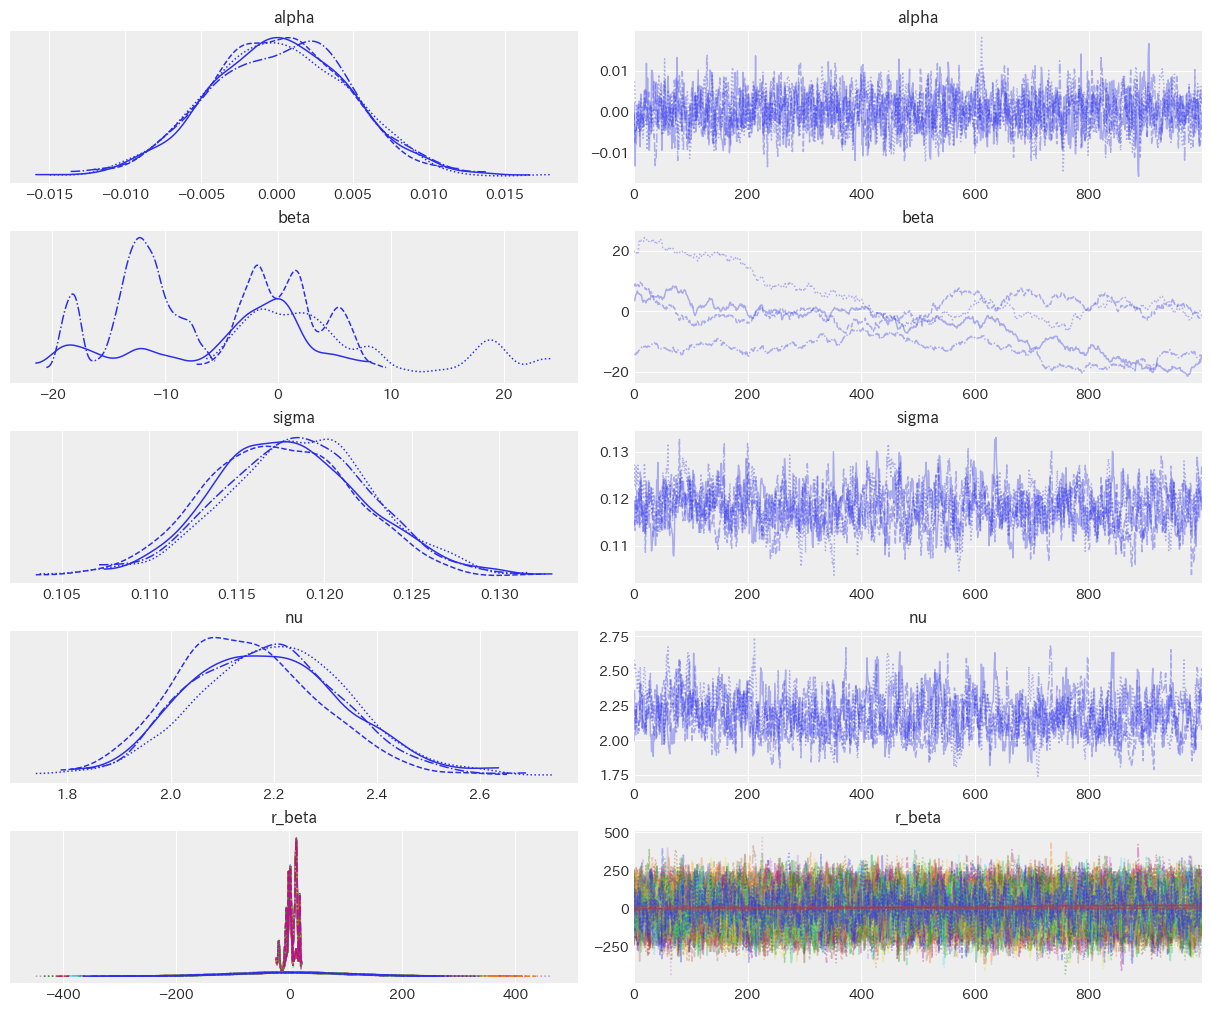

In [49]:
az.plot_trace(trace_h, var_names=['alpha', 'beta', 'sigma', 'nu', 'r_beta']);

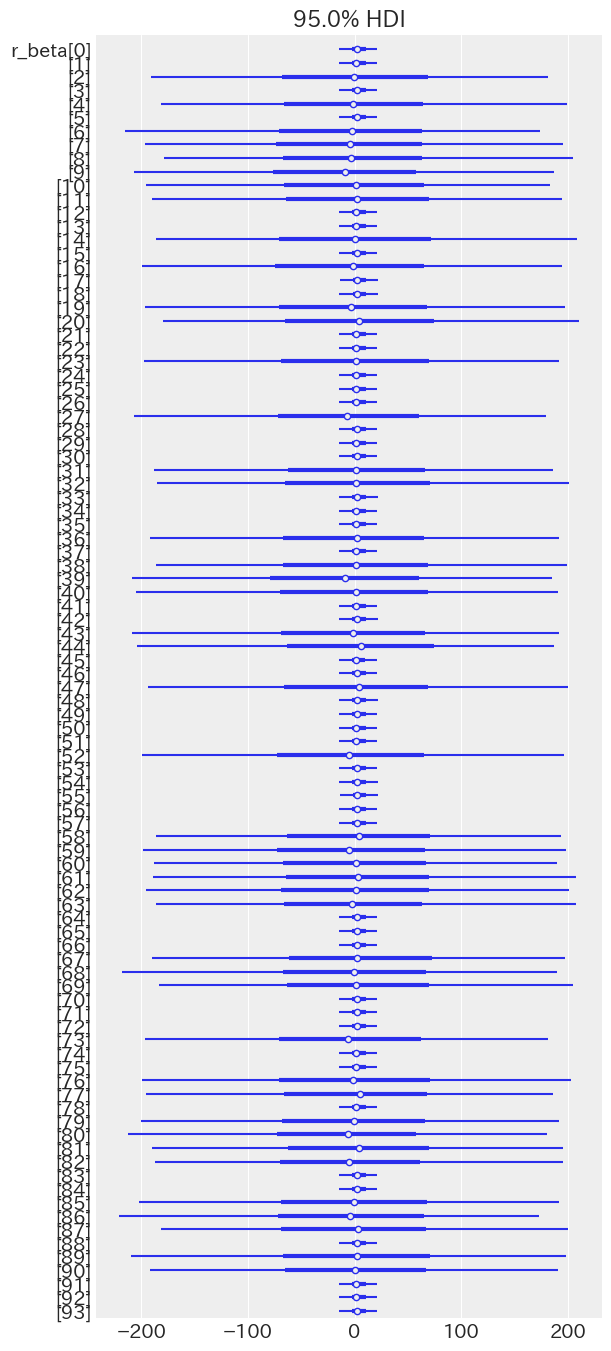

In [50]:
az.plot_forest(trace_h, var_names=['r_beta'], combined=True, hdi_prob=.95);

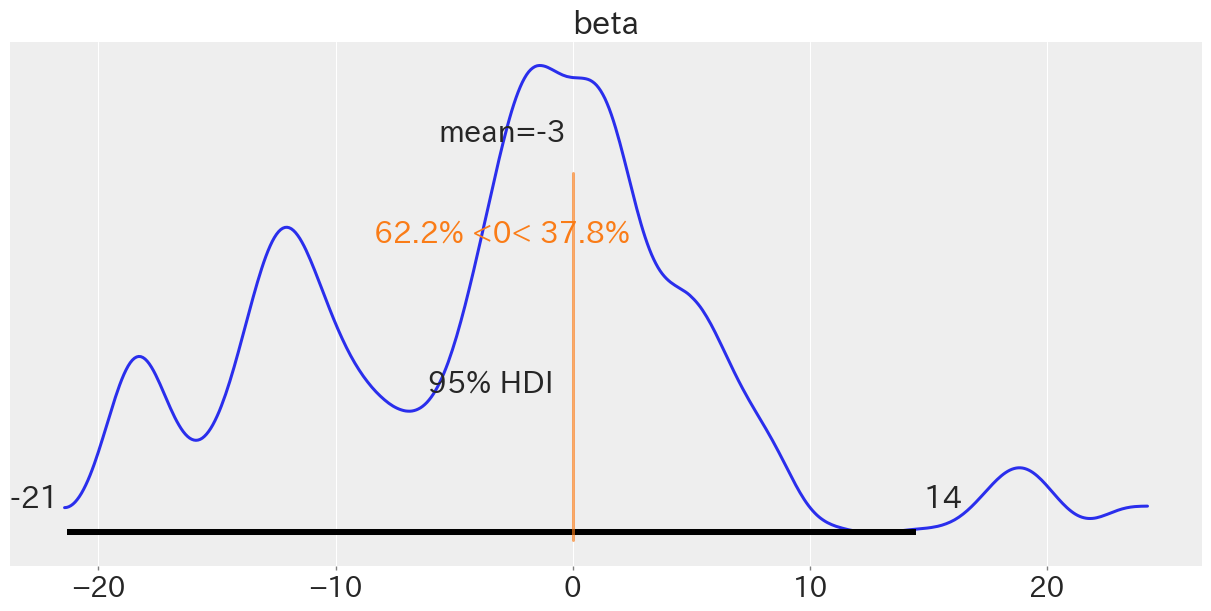

In [51]:
az.plot_posterior(trace_h, var_names=['beta'], ref_val=0, hdi_prob=.95, figsize=(12, 6));

In [127]:
with model_h:
    pm.compute_log_likelihood(trace_h)

Output()

In [128]:
az.waic(trace_h)

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3339.52    37.20
p_waic       37.76        -

There has been a warning during the calculation. Please check the results.

In [129]:
with model_h:
    pm.sample_posterior_predictive(trace_h, extend_inferencedata=True)

Sampling: [y_obs_observed]


Output()

<Axes: xlabel='y_obs_observed'>

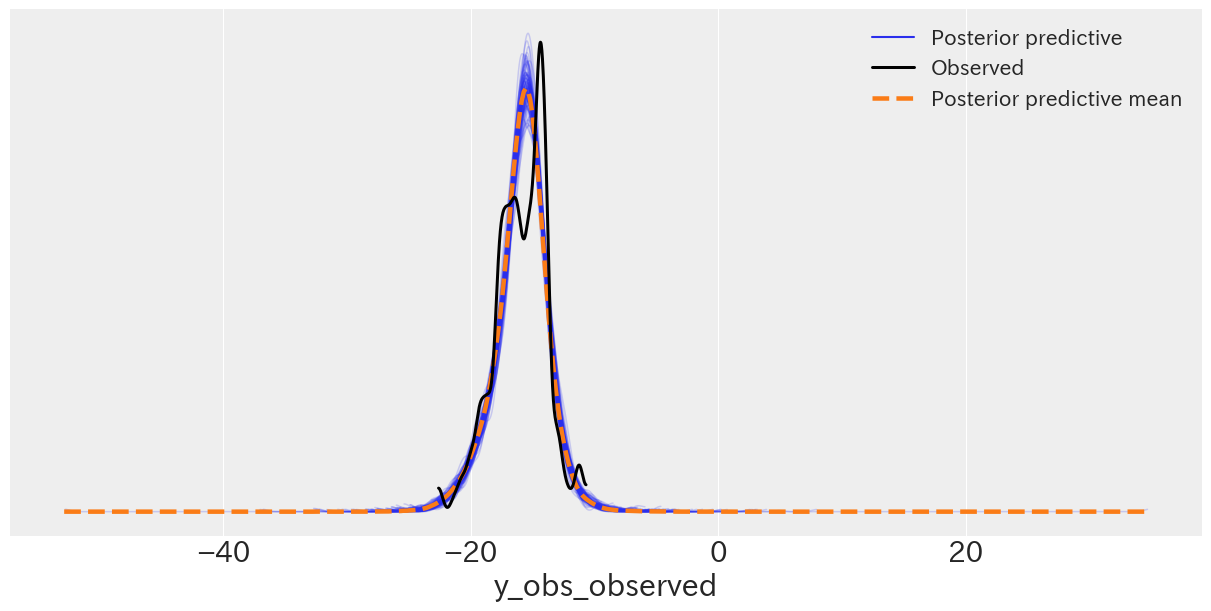

In [130]:
az.plot_ppc(trace_h, num_pp_samples=100, kind='kde', figsize=(12, 6))

## ランダム係数モデル

### ベイズモデル

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


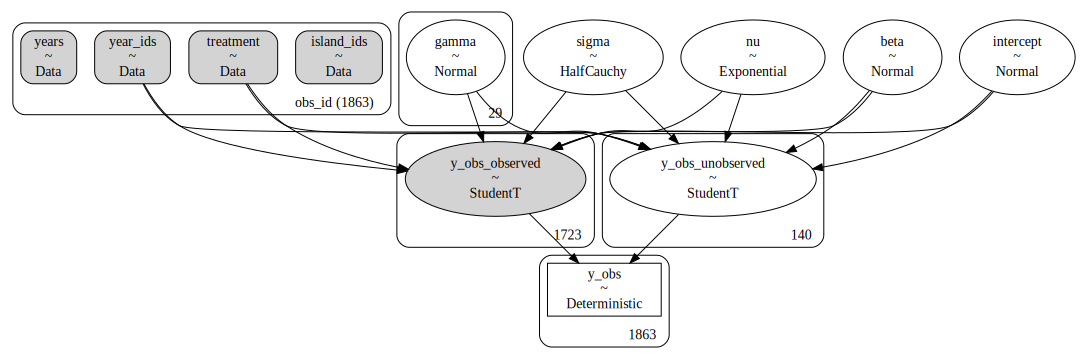

In [ ]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
year_ids, unique_year_ids = pd.factorize(df['year'])

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as twfe_student_t:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    year_ids = pm.Data('year_ids', year_ids, dims='obs_id')
    years = pm.Data('years', df['year'], dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    gamma = pm.Normal('gamma', mu=0, sigma=1, shape=len(unique_year_ids))
    beta_rnd = pm.Normal('beta_rnd', mu=0, sigma=1, shape=len(unique_island_ids))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_fix = pm.Normal('beta_fix', mu=0, sigma=1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    nu = pm.Exponential('nu', lam=1/30)

    # conbine fixed and random effects
    beta = beta_fix + beta_rnd[island_ids]

    # expectation
    mu = intercept + beta * treatment + gamma[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_centered'])

pm.model_to_graphviz(twfe_student_t)

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


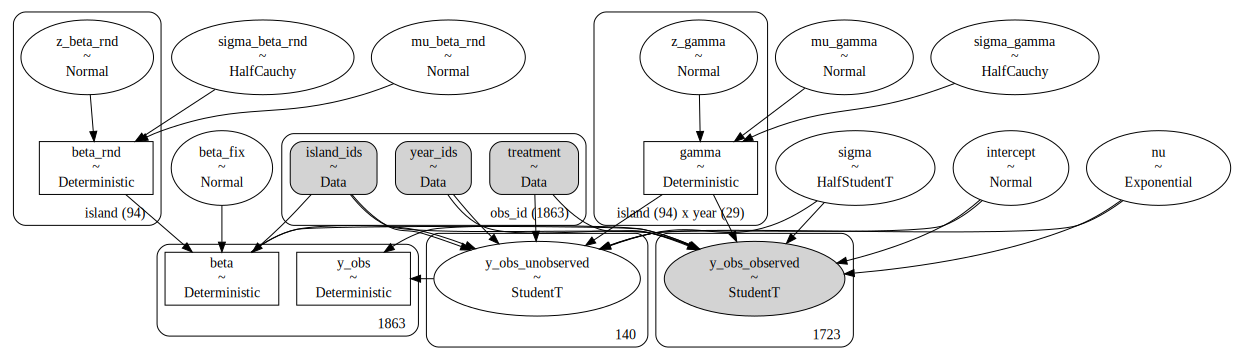

In [4]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year_ids'], unique_year_ids = pd.factorize(df['year'])

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year_ids'], dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=1)
    sigma_gamma = pm.HalfCauchy('sigma_gamma', beta=1)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=1, shape=(len(unique_island_ids), len(unique_year_ids)), dims=('island', 'year'))
    gamma = pm.Deterministic('gamma', mu_gamma + z_gamma * sigma_gamma, dims=('island', 'year'))

    mu_beta_rnd = pm.Normal('mu_beta_rnd', mu=0, sigma=1)
    sigma_beta_rnd = pm.HalfCauchy('sigma_beta_rnd', beta=1)
    z_beta_rnd = pm.Normal('z_beta_rnd', mu=0, sigma=1, shape=len(unique_island_ids), dims='island')
    beta_rnd = pm.Deterministic('beta_rnd', mu_beta_rnd + z_beta_rnd * sigma_beta_rnd, dims='island')

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    beta_fix = pm.Normal('beta_fix', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)
    nu = pm.Exponential('nu', lam=1/30)

    # combine fixed and random effects
    beta = pm.Deterministic('beta', beta_fix + beta_rnd[island_ids])

    # expectation
    mu = intercept + beta * treatment + gamma[island_ids, year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_centered'])

pm.model_to_graphviz(model_h)

In [5]:
with model_h:
    trace_h = pm.sample(
        draws=1500,
        tune=1500,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
summary = az.summary(trace_h, hdi_prob=.95)
summary.head()

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / withi

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_gamma,-0.039,0.706,-1.395,1.348,0.017,0.012,1704.0,2138.0,1.0
"z_gamma[0, 0]",-0.011,0.977,-1.961,1.760,0.018,0.017,3018.0,2371.0,1.0
"z_gamma[0, 1]",-0.010,1.014,-1.999,1.942,0.018,0.019,3348.0,2090.0,1.0
"z_gamma[0, 2]",-0.016,1.010,-1.910,2.002,0.017,0.020,3739.0,2192.0,1.0
"z_gamma[0, 3]",0.015,0.987,-1.982,1.896,0.017,0.017,3289.0,2268.0,1.0


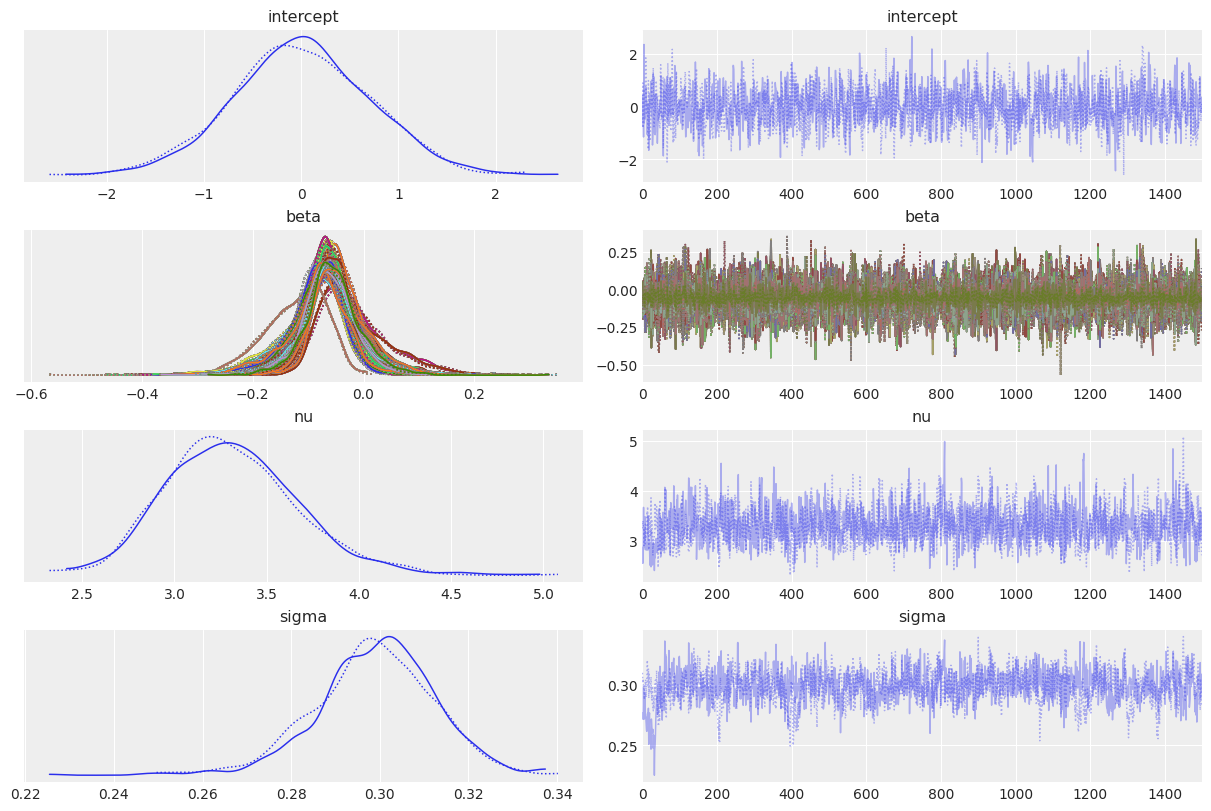

In [7]:
az.plot_trace(trace_h, var_names=['intercept', 'beta', 'nu', 'sigma']);

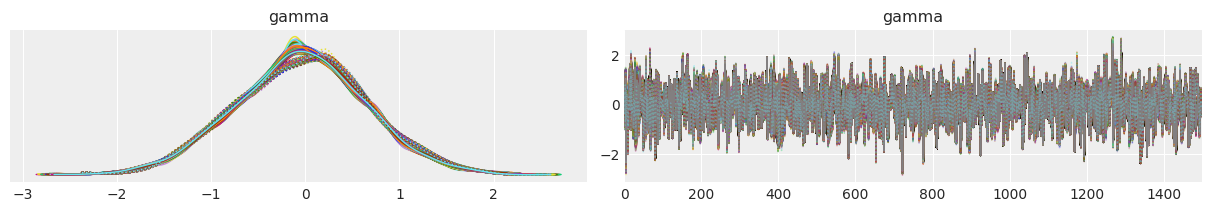

In [10]:
az.plot_trace(trace_h, var_names=['gamma']);

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1863) in plot_posterior, generating only 40 plots
  warnings.warn(


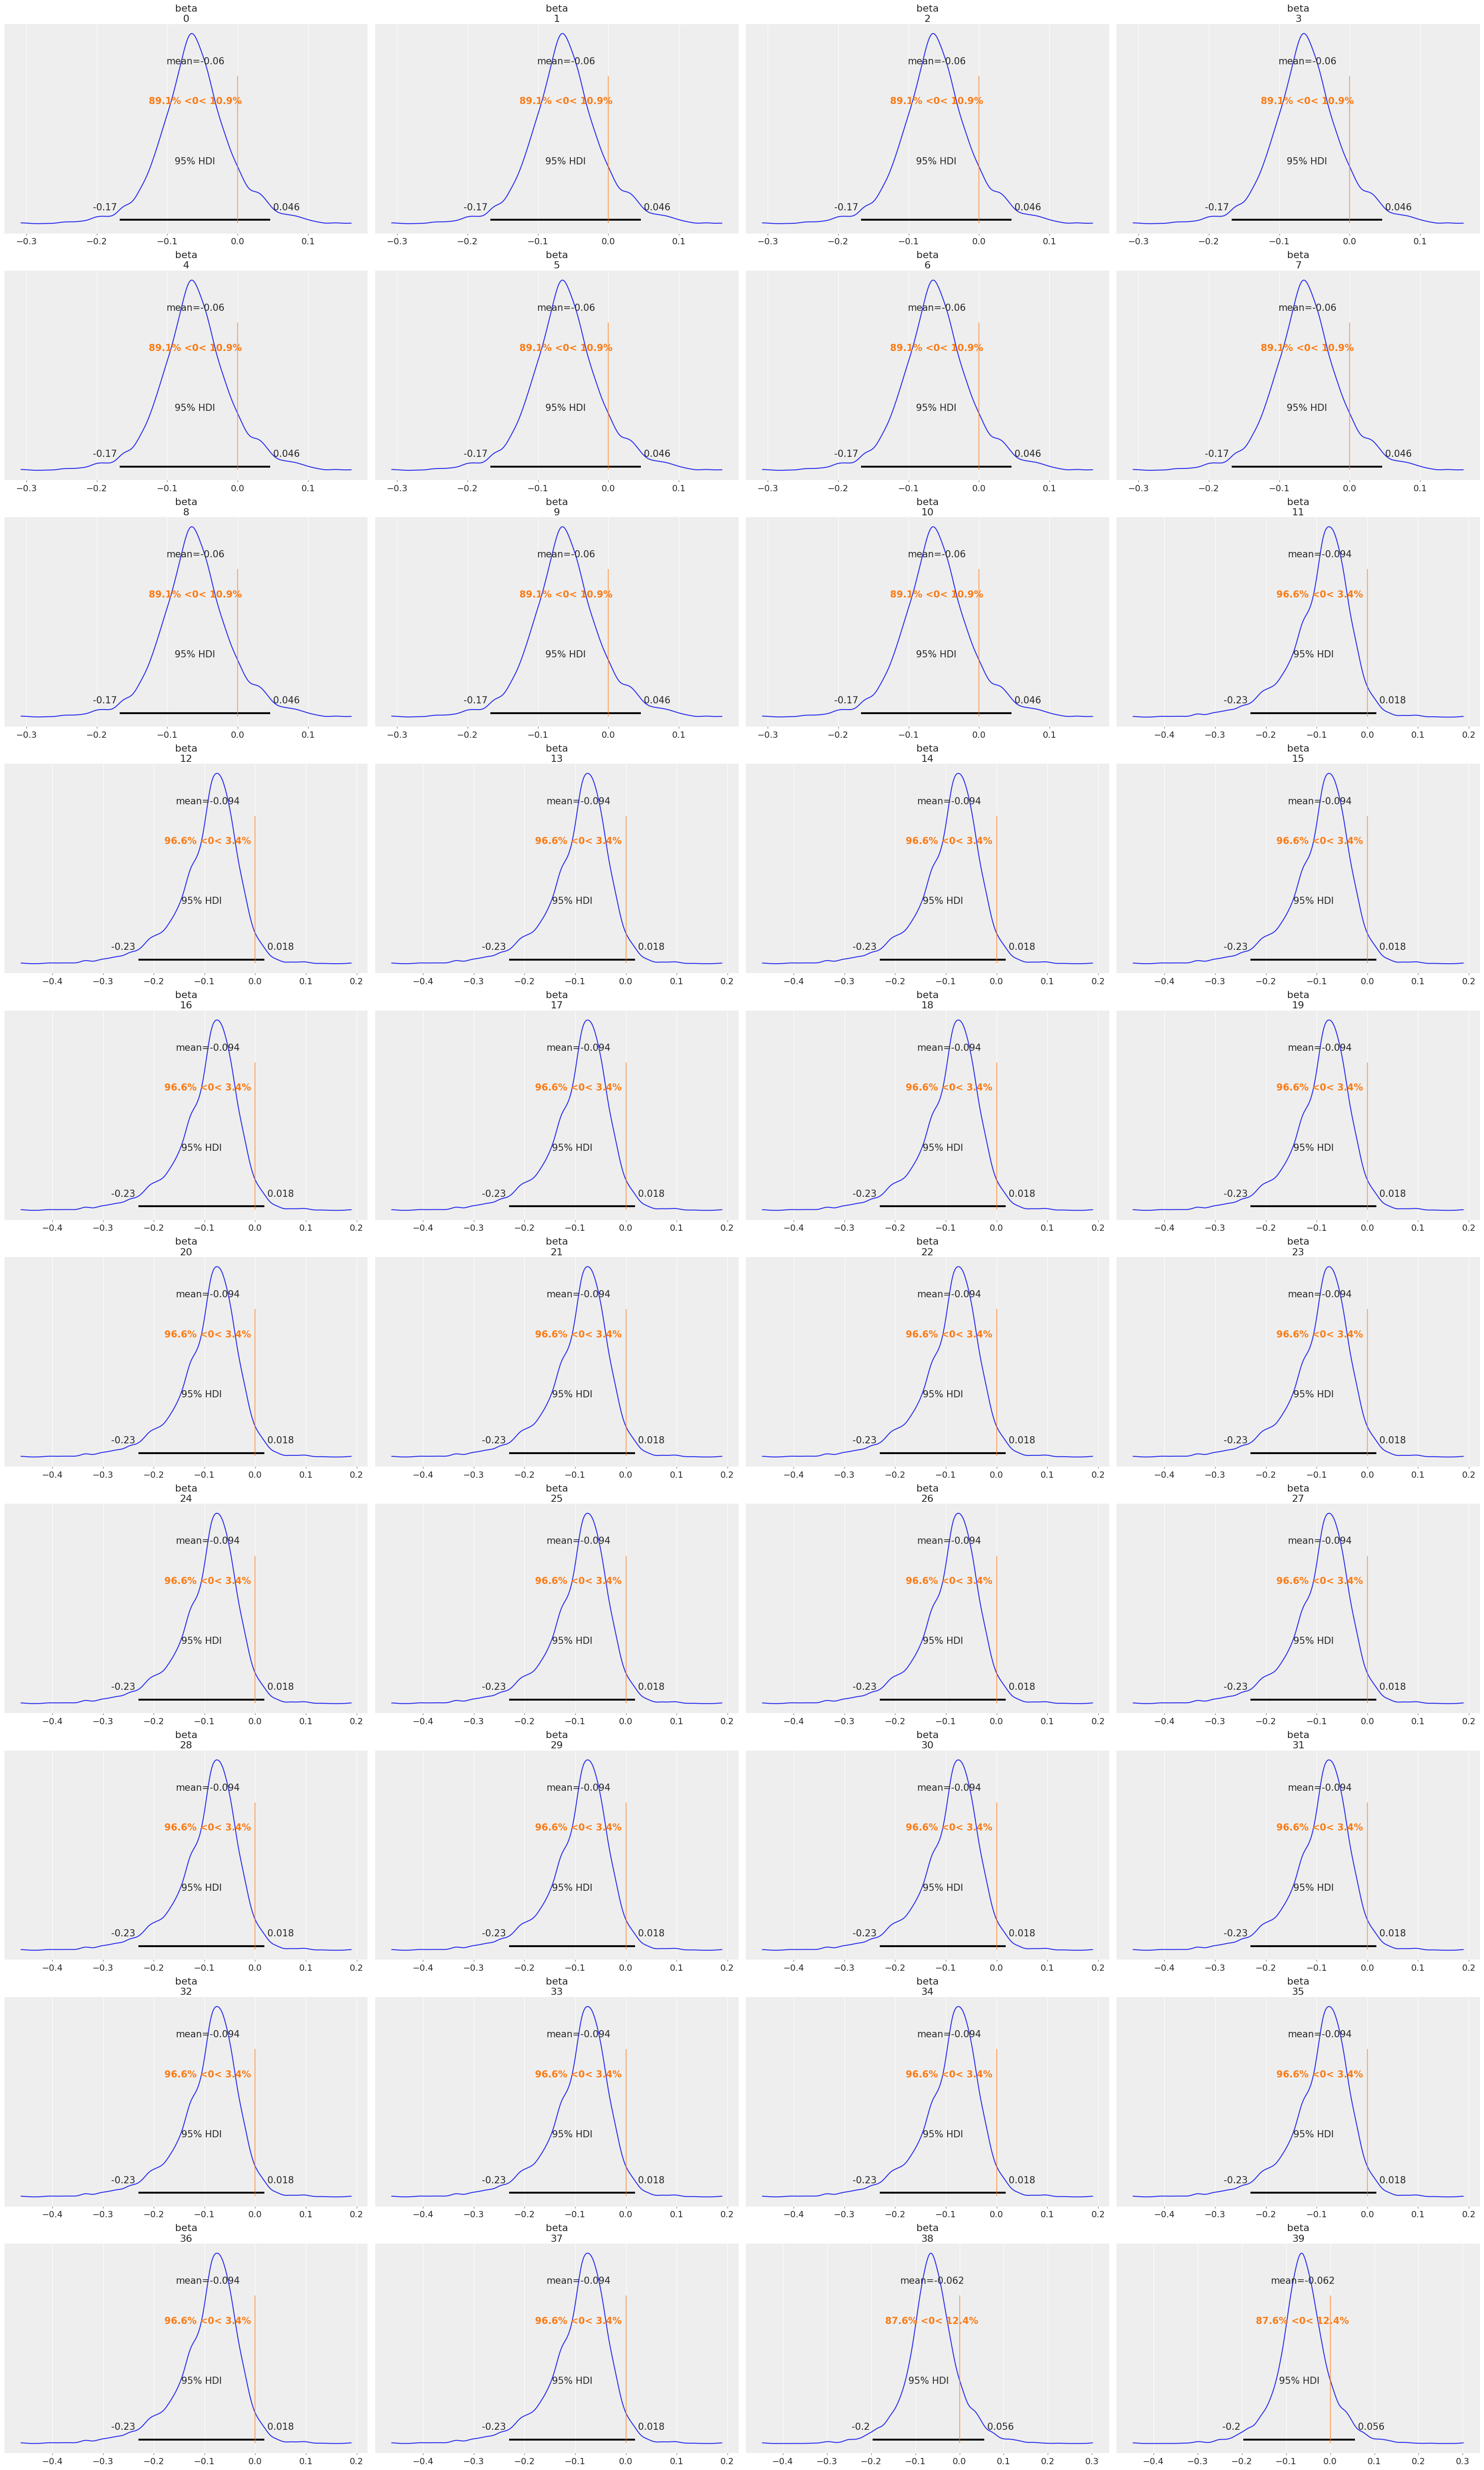

In [13]:
az.plot_posterior(trace_h, var_names=['beta'], hdi_prob=.95, ref_val=0);

In [17]:
with model_h:
    pm.compute_log_likelihood(trace_h)

Output()

ValueError: ['log_likelihood'] group(s) already exists.

In [18]:
az.waic(trace_h)

Computed from 3000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -946.45    42.06
p_waic       49.53        -

## サンプリングの保存

In [65]:
az.to_netcdf(trace, './mcmc_sample/twfe.nc')
# az.to_netcdf(trace_h, './mcmc_sample/twfe_h.nc')
# az.to_netcdf(trace_h, './sample/traces_twfe_student_t_log.nc')
# az.to_netcdf(trace_h, './mcmc_sample/traces_twfe_h_random_slope.nc')

'./mcmc_sample/twfe.nc'

## サンプリングのインポート

In [75]:
trace = az.from_netcdf('./mcmc_sample/twfe.nc')
# trace_h = az.from_netcdf('./sample/twfe_h.nc')
# trace_twfe_student_t = az.from_netcdf('./sample/traces_twfe_student_t_log.nc')
# trace_twfe_h_student_t = az.from_netcdf('./sample/traces_twfe_h_student_t_log.nc')